In [1]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset paths (adjust paths if necessary)
image_dir = '/kaggle/input/sigment/data/2d_images'
mask_dir = '/kaggle/input/sigment/data/2d_masks'

# Function to load images and masks
def load_medical_images_and_masks(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for img_name in os.listdir(image_dir):
        # Load medical image (assuming grayscale)
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, img_size)  # Resize to 128x128
        img = img / 255.0  # Normalize to [0, 1]
        
        # Load corresponding mask
        mask_name = img_name.replace('.png', '_mask.png')  # Adjust mask name format if needed
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize mask to [0, 1]
        
        # Append to lists
        images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
        masks.append(np.expand_dims(mask, axis=-1))  # Add channel dimension
    
    return np.array(images), np.array(masks)

# Load the images and masks
images, masks = load_medical_images_and_masks(image_dir, mask_dir)

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Print dataset size
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")


Training set: 213 images
Validation set: 54 images


# Define U-Net Model
This is the U-Net model tailored for grayscale medical images:

In [2]:
# U-Net model definition for grayscale images
def unet_model(input_size=(128, 128, 1)):  # Adjust input shape for grayscale images
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
model = unet_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


# Train the Model
Train the U-Net model using the preprocessed images and masks:

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True)
train_gen = train_datagen.flow(train_images, train_masks, batch_size=16)

# Training the model
history = model.fit(train_gen, validation_data=(val_images, val_masks), epochs=25, batch_size=16)

# Save the model after training
model.save('unet_medical_segmentation_model.h5')


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727374367.078490     102 service.cc:145] XLA service 0x7a95cc007090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727374367.078555     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7552 - loss: 0.6478

I0000 00:00:1727374375.628561     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1727374375.633751     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - accuracy: 0.7563 - loss: 0.6109 - val_accuracy: 0.7542 - val_loss: 0.5249
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7635 - loss: 0.5259 - val_accuracy: 0.7542 - val_loss: 0.4730
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7717 - loss: 0.4416 - val_accuracy: 0.8990 - val_loss: 0.2526
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8759 - loss: 0.2973 - val_accuracy: 0.9199 - val_loss: 0.2095
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8929 - loss: 0.2615 - val_accuracy: 0.9455 - val_loss: 0.1538
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9119 - loss: 0.2112 - val_accuracy: 0.9463 - val_loss: 0.1359
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9059 - loss: 0.2256 - val_accuracy: 0.9604 - val_loss: 0.1230
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9137 - loss: 0.2033 - val_accuracy: 0.9540 - val_loss: 

# Evaluate and Visualize Results
Evaluate the performance and visualize the predicted masks compared to the original ones:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


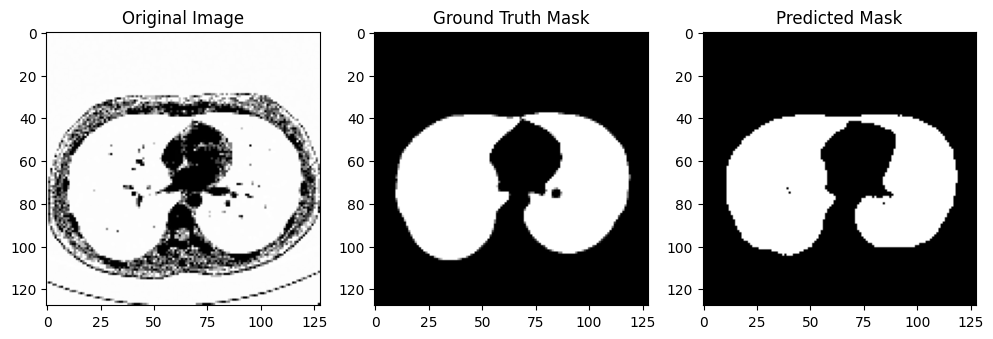

In [4]:
# Function to visualize results
def visualize_segmentation(image, mask, prediction):
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Original Image")
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()

# Visualize on a random sample from validation set
index = 5  # Example index
predicted_mask = model.predict(val_images[index:index+1])[0].round()

visualize_segmentation(val_images[index], val_masks[index], predicted_mask)


# Conclusion
This code loads your medical images dataset in Kaggle, builds the U-Net model, trains it, and then evaluates the results. You can visualize the output to verify the segmentation results.

Make sure to adjust the image and mask paths in the notebook to fit the dataset structure on Kaggle. Let me know if you need further guidance!